# Homework 3, Question 2: Quantum Phase Estimation

Implement the phase-estimation circuit to find the eigenvalue associated with eigenvector 

$|u\rangle = \frac{1}{\sqrt{2}}(|0\rangle - i|1\rangle)$

of the unitary matrix 

$\hat{U}_Y = \begin{bmatrix} 1 & -i \\ i & 1 \end{bmatrix}$

(Hint: Two-bit precision will be enough for the purpose of this task!)

In [42]:
#@title Install Qiskit and other dependencies
!pip install qiskit qiskit-aer qiskit-ibm-runtime pylatexenc

In [50]:
#@title Imports
import argparse
import math
import matplotlib.pyplot as plt
from ipywidgets import interact
from qiskit import  ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeProviderForBackendV2 as FakeProvider
from qiskit.circuit.library import QFT
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [44]:
#@title Functions
def make_circuit(operator="RX", theta=63 * math.pi / 32, eigenvector="e1", bits=6):
    input_qubit = 0
    n = bits

    qubits = QuantumRegister(n+1, "q")
    clbits = ClassicalRegister(n, "c")
    circuit = QuantumCircuit(qubits, clbits)

    # Input state
    if operator == "Z":
        if eigenvector == "e0":
            circuit.x(input_qubit)
    elif operator == "Y":
        if eigenvector == "e0":
            circuit.rx(math.pi/2, input_qubit)
        else:
            circuit.rx(-math.pi/2, input_qubit)
    else:
        if eigenvector == "e0":
            circuit.ry(math.pi/2, input_qubit)
        else:
            circuit.ry(-math.pi/2, input_qubit)

    # Prepare input for QFT:
    for i in range(n):
        circuit.h(i+1)
    for i in range(n):
        if operator == "Z" and i % 2 == 1:
            circuit.cz(n-i, input_qubit)
        elif operator == "Y" and i % 2 == 1:
            circuit.cy(n-i, input_qubit)
        elif operator == "RX":
            circuit.crx(theta*(2**(n-i-1)), n-i, input_qubit)

    # QFT:
    circuit.append(QFT(n).inverse(), qubits[1:])

    # Measure:
    circuit.measure(qubits[1:], clbits)

    return circuit

def run_circuit(circuit, shots=1024):
    backend = AerSimulator()
    sampler = Sampler(backend)
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(circuit)
    job = sampler.run([isa_circuit], shots=shots)
    result = job.result()
    return dict(sorted(result[0].data.c.get_counts().items()))

def print_counts(counts):
    for k, v in counts.items():
        print(f"{k}: {v}")

def plot_counts(counts):
    plt.figure(figsize=(12, 6))
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('Measurement Outcome')
    plt.ylabel('Counts')
    plt.title('Histogram of Measurement Outcomes')
    plt.xticks(rotation=90)
    plt.show()

In [55]:
circuit = make_circuit(operator="Y", eigenvector="e0", bits=6)
counts = run_circuit(circuit)

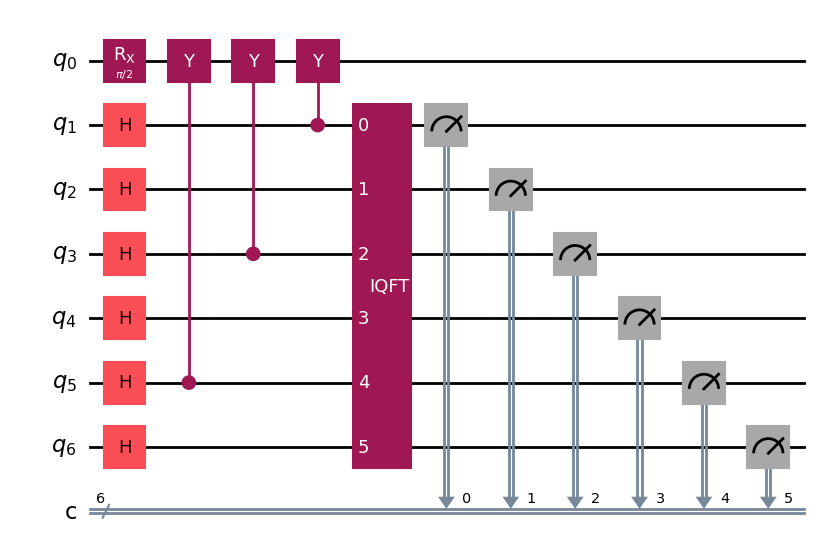

In [56]:
circuit.draw(output="mpl")

In [54]:
print_counts(counts)

000010: 2
000110: 24
001010: 36
001110: 3
010010: 1
010110: 112
011010: 283
011110: 75
100010: 66
100110: 261
101010: 105
101110: 3
110010: 2
110110: 27
111010: 23
111110: 1


In [ ]:
plot_counts(counts)

In [52]:
def run_all(operator="RX", theta=63 * math.pi / 32, eigenvector="e1", bits=6, shots=1024):
    circuit = make_circuit(operator=operator, theta=theta, eigenvector=eigenvector, bits=bits)
    counts = run_circuit(circuit=circuit, shots=shots)
    # print_counts(counts)
    plot_counts(counts)

interact(run_all, operator=["RX", "Z", "Y"], theta=(0, 2*math.pi, 0.1), eigenvector=["e0", "e1"], bits=(1, 10), shots=(1, 1024, 1))

interactive(children=(Dropdown(description='operator', options=('RX', 'Z', 'Y'), value='RX'), FloatSlider(valu…

<function __main__.run_all(operator='RX', theta=6.1850105367549055, eigenvector='e1', bits=6, shots=1024)>